### Project 1
#### Infrastructure Investment & Jobs Act Funding Allocation

#### **Data source**: 
1) Funding allocation of the Infrastructure Investment and Jobs Act funding by State and Territory
2) Population by state data source: https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html
3) Political party affiliation data source: https://www.cnn.com/election/2020/results/president

#### **questions to answer:**:
1) Is the allocation equitable based on the population of each of the States and Territories, or is bias apparent?
2) Does the allocation favor the political interests of the Biden administration?

#### Loading data:

In [149]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

#Load the dataset:
df = pd.read_excel('IIJA FUNDING AS OF MARCH 2023.xlsx', sheet_name='Sheet1')
df_pop = pd.read_excel('NST-EST2024-CHG.xlsx', sheet_name='Sheet1')

We will clean and merge the two datasets:

**Note: only 51 states will be included in this study. Minor US territories will not be included.**

**Political party affiliations will be also assigned according to the data source from CNN**

In [125]:
#To standardize the state column names for merging:
df_pop['States'] = df_pop['States'].str.replace('.', '', regex=False).str.lower()

df['State, Teritory or Tribal Nation'] = df['State, Teritory or Tribal Nation'].astype(str)
df['State, Teritory or Tribal Nation'] = df['State, Teritory or Tribal Nation'].str.lower()
df.rename(columns={'State, Teritory or Tribal Nation': 'States'}, inplace=True)

#The funding dataset has a typo in Delaware, we will fix it:
df['States'] = df['States'].replace('deleware', 'delaware')

#We will perform a left join to keep all states in the funding dataset:
df_merged = df_pop.merge(df, how='left', on='States')

#Assigning political party affiliations based on the 2020 presidential election results:
demo_states = [
    "arizona",
    "california",
    "colorado",
    "connecticut",
    "delaware",
    "district of columbia",
    "georgia",
    "hawaii",
    "illinois",
    "maine",
    "maryland",
    "massachusetts",
    "michigan",
    "minnesota",
    "nevada",
    "new hampshire",
    "new jersey",
    "new mexico",
    "new york",
    "oregon",
    "pennsylvania",
    "virginia",
    "washington",
    "wisconsin"
]

df_merged['party'] = df_merged['States'].apply(lambda x: 'Democrat' if x in demo_states else 'Republican')

#Adjust the population column to millions for easier visualization:
df_merged['2020_population'] = df_merged['2020_population'] / 1_000_000
df_merged.rename(columns={'2020_population': '2020_population(millions)'}, inplace=True)

Confirming the merged dataset is free of missing values and have all 51 states:

In [126]:
print('Number of States:\n', df_merged['States'].count())
print('-'*40)
print('Missing values in each column:\n', df_merged.isnull().sum())

Number of States:
 51
----------------------------------------
Missing values in each column:
 States                       0
2020_population(millions)    0
Total (Billions)             0
party                        0
dtype: int64


In [127]:
df_merged.head()

,States,2020_population(millions),Total (Billions),party
0,alabama,5.033094,3.0,Republican
1,alaska,0.733017,3.7,Republican
2,arizona,7.187135,3.5,Democrat
3,arkansas,3.014546,2.8,Republican
4,california,39.521958,18.4,Democrat


### 1) How are the funds being allocated to each state by their political affiliation?

Text(-0.05000000000000002, 4, 'less funding allocated to\nRepublican states')

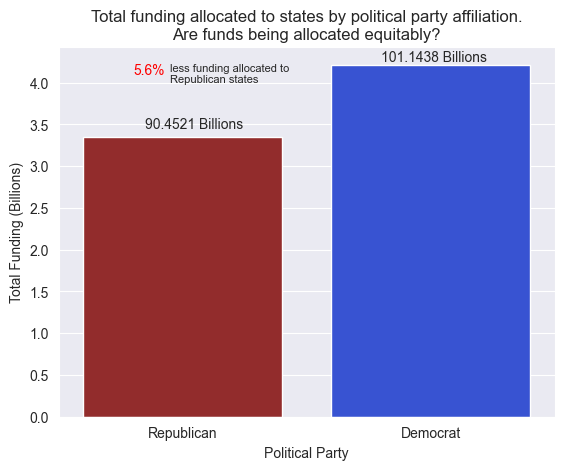

In [128]:
demo_fund = df_merged.groupby('party')['Total (Billions)'].sum()['Democrat']
repub_fund = df_merged.groupby('party')['Total (Billions)'].sum()['Republican']

sns.barplot(df_merged,
            x = 'party',
            y = 'Total (Billions)',
            hue = 'party',
            palette={'Democrat': "#1E43EC", 'Republican': "#A31B1B"},
            errorbar=None)
plt.title('Total funding allocated to states by political party affiliation.\nAre funds being allocated equitably?')
plt.xlabel('Political Party')
plt.ylabel('Total Funding (Billions)')
plt.text(-0.15, 3.5, f'{repub_fund} Billions', va='center')
plt.text(0.8, 4.3, f'{demo_fund} Billions', va='center')
plt.text(-0.2, 4.1, f'{(demo_fund - repub_fund) / (demo_fund + repub_fund)*100:.1f}%', fontsize=10, color='red')
plt.text(-0.2 + 0.15, 4, 'less funding allocated to\nRepublican states', fontsize=8)



Figure 1: Total funding allocation to states by political party.

### 2) Does less funding mean less population in those states?

Text(-0.2, 7.0, 'less population\nin Republican states')

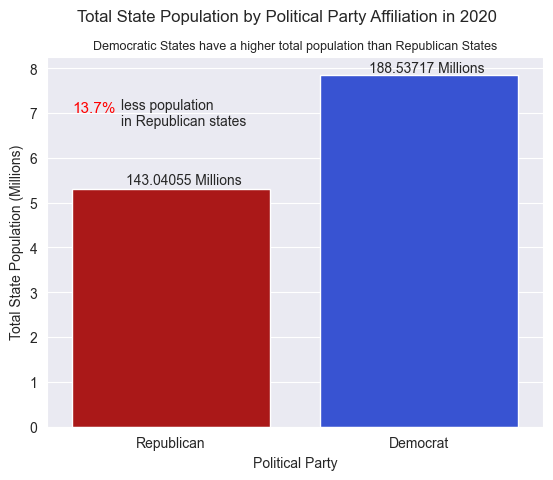

In [129]:
demo_pop = df_merged.groupby('party')['2020_population(millions)'].sum()['Democrat']
repub_pop = df_merged.groupby('party')['2020_population(millions)'].sum()['Republican']

sns.barplot(df_merged,
            x = 'party',
            y = '2020_population(millions)',
            errorbar=None,
            palette={'Democrat': "#1E43EC", 'Republican': "#C20000"},
            hue = 'party')
plt.suptitle('Total State Population by Political Party Affiliation in 2020')
plt.title('Democratic States have a higher total population than Republican States', fontsize=9)
plt.xlabel('Political Party')
plt.ylabel('Total State Population (Millions)')
plt.text(-0.18, 5.5, f'{repub_pop} Millions', va='center')
plt.text(0.8, 8, f'{demo_pop} Millions', va='center')
plt.text(-0.4, 7.1, f'{((demo_pop - repub_pop)/(repub_pop+demo_pop))*100:.1f}%', color = 'red', va='center', fontsize=11)
plt.text(-0.4 + 0.2, 7.0, 'less population\nin Republican states', va='center', fontsize=10)

Figure 2: States population sizes by political affiliation.

### 2) Does funding allocations correlate with state population?

Text(0.5, 1.0, 'Strong positive correlation between state population and funding allocation')

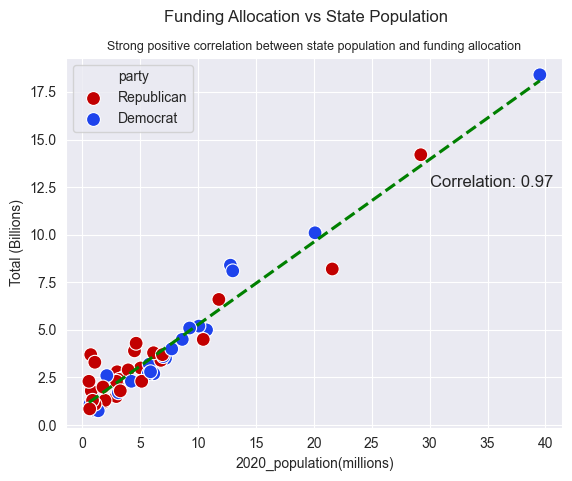

In [130]:
sns.scatterplot(data=df_merged, 
                x = '2020_population(millions)', 
                y = 'Total (Billions)', 
                hue = 'party', 
                palette={'Democrat': "#1E43EC", 'Republican': "#C20000"},
                s = 100
                )

#Calculate the correlation between population and funding:
corr = df_merged['2020_population(millions)'].corr(df_merged['Total (Billions)'])

sns.regplot(data = df_merged, 
            x = '2020_population(millions)', 
            y = 'Total (Billions)', 
            scatter = False,
            ci = None,
            line_kws = {'color': 'green', 'linestyle': 'dashed'}            
            )

plt.text(30, 12.5, f'Correlation: {corr:.2f}', fontsize=12)
sns.set_style('darkgrid')
plt.suptitle('Funding Allocation vs State Population')
plt.title('Strong positive correlation between state population and funding allocation', fontsize=9)

Figure 3: There is a strong linear relationship between state population and the amount of funding being given to the state. Funds are being allocated equitable to the population size.

### 3) Since Biden was selected as president in 2020, does the allocation favor the political interests of the Biden administration?

Text(0.1, 4300, 'The per capita scale of Republican States\nis much more than Democratic States\ndespite Biden was elected')

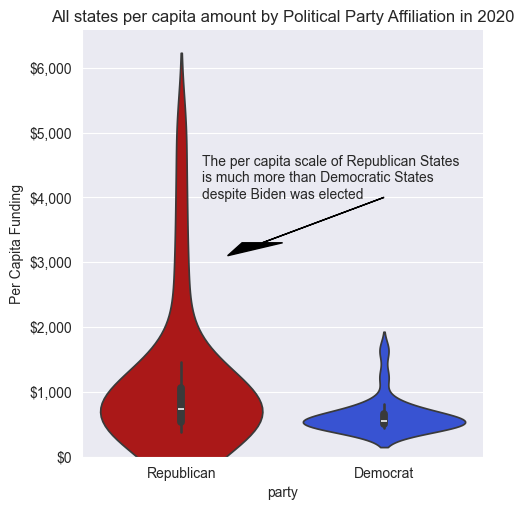

In [197]:
g = sns.catplot(data=df_merged,
            x = 'party',
            y = 'per_capita_funding',
            hue = 'party',
            kind = 'violin',
            palette={'Democrat': "#1E43EC", 'Republican': "#C20000"})
g.set(ylim=(0, None))

g.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.ylabel('Per Capita Funding')
plt.title('All states per capita amount by Political Party Affiliation in 2020')

plt.arrow(1, 4000, -0.6, -700, head_width=0.2, head_length=200, fc='black', ec='black')
plt.text(0.1, 4300, 'The per capita scale of Republican States\nis much more than Democratic States\ndespite Biden was elected', va='center')


Figure 4: Violin plot that shows the scale of Republican States are receiving much more fund per capita than Democratic States.

Text(0.45, 950, 'than Democratic states')

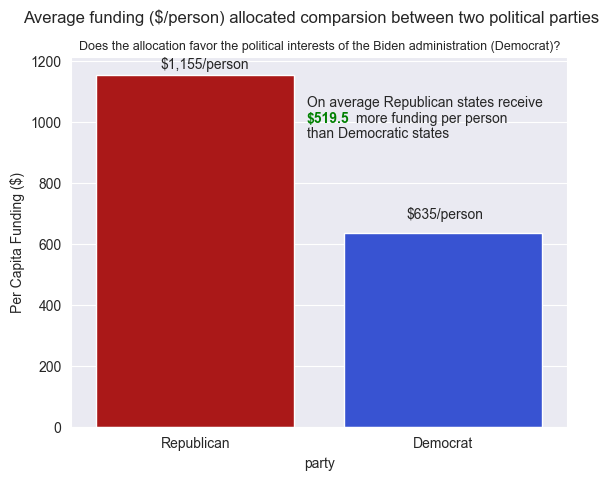

In [196]:
df_merged['per_capita_funding'] = (df_merged['Total (Billions)'] * 1_000_000_000) / (df_merged['2020_population(millions)'] * 1_000_000)
demo_avg_pc = df_merged[df_merged['party'] == 'Democrat']['per_capita_funding'].mean()
repub_avg_pc = df_merged[df_merged['party'] == 'Republican']['per_capita_funding'].mean()

sns.barplot(df_merged,
            x = 'party',
            y = 'per_capita_funding',
            errorbar=None,
            palette={'Democrat': "#1E43EC", 'Republican': "#C20000"},
            hue = 'party')

plt.ylabel('Per Capita Funding ($)')
plt.text(-0.14, 1190, f'${df_merged.groupby("party")["per_capita_funding"].mean()["Republican"]:,.0f}/person', va='center')
plt.text(0.85, 700, f'${df_merged.groupby("party")["per_capita_funding"].mean()["Democrat"]:,.0f}/person', va='center')
plt.suptitle('Average funding ($/person) allocated comparsion between two political parties')
plt.title('Does the allocation favor the political interests of the Biden administration (Democrat)?', fontsize=9)

plt.text(0.45, 1000,'On average Republican states receive\n', fontsize=10)
plt.text(0.45, 1000, f'${repub_avg_pc - demo_avg_pc:.1f}',fontsize=10, color = 'green', weight = 'bold')
plt.text(0.45+0.2, 1000, 'more funding per person', fontsize=10)
plt.text(0.45, 950, 'than Democratic states', fontsize=10)

              

Figure 5: Comparison between the average per capita for Republican States and Democrat States. On average, Republican States receives more funding per person in each of thier states than Democrats.

Summary:
1) Is the allocation equitable based on the population of each of the States and Territories, or is bias apparent?

    Ans: The initial assessment by the total fund allocation may seem to show that funding allocation is biased towards Democratic States (Figure 1). However, as shown in Figure 2 and 3, the population in Democratic states justifies the additional funding that they received. The funding allocation and population size has a 0.97 correlation, suggesting that the funding and population is strongly proportional and there is not much bias.

2) Does the allocation favor the political interests of the Biden administration?

    Ans: Although a democratic president was elected in 2020, figure 4 and 5 showed that Republican States were actually receiving more funding on a per person basis than democratic states. On average, Republican States receive $519 per person than democratic states. Thus, there was not allocation favor that benefits the democratic state despite a democratic president was elected.